In [1]:
from pathlib import Path
from scipy.interpolate import griddata
from ssmlearnpy import SSMLearn
from ssmlearnpy.utils.plots import Plot
import matplotlib.pyplot as plt
import numpy as np

## Pre-processing

### Load data

In [2]:
# SET PARAMETERS BELOW
DATA_PATH = "/Users/njo20/Documents/ERCOFTAC/ssm-model-reduction/data/"
BETA = 1.35
RE_VALS = [50, 80, 100, 120, 200]
TRUNC_INDEX = 300
DIM = 1  # 0 for u, 1 for v
DEGREE = 3

# DO NOT EDIT
DATA_PATH = Path(DATA_PATH)
BETA = str(BETA).replace(".", "_")

PATH = DATA_PATH / f"beta_{BETA}"

In [3]:
# Load data
data = []
for re in RE_VALS:
    path = PATH / f"Re_{re}.npy"
    in_data = np.load(path)[0, ...]

    in_data = np.split(in_data, 2, axis=-1)
    data.append(np.stack(in_data, axis=-1))

In [4]:
# Load coordinates
path = PATH / "coordinates.npy"
coords = np.load(path)

### Plot velocity field

In [5]:
# Extract pairwise coordinates
x, y = coords[..., 0].flatten(), coords[..., 1].flatten()

In [6]:
# Create a regular mesh
ngridx, ngridy = 131, 100
xi = np.linspace(np.min(x), np.max(x), ngridx)
yi = np.linspace(np.min(y), np.max(y), ngridy)

In [7]:
# Interpolate onto a regular mesh
path = Path("/Users/njo20/Documents/ERCOFTAC/ssm-model-reduction/data/100/beta_1_35_reg.npy")

try:
    reg_data = np.load(path)
    np.save(path, reg_data)
except:
    reg_data = np.zeros((data.shape[0], ngridy, ngridx, 2))
    for i, time_slice in enumerate(data):
        for j in range(2):
            reg_data[i, ..., j] = griddata((x, y), time_slice[:, j].flatten(), (xi[np.newaxis, :], yi[:, np.newaxis]), method='linear')

AttributeError: 'list' object has no attribute 'shape'

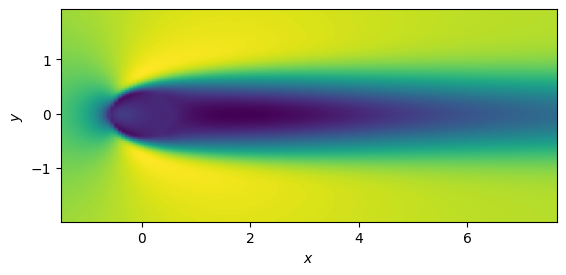

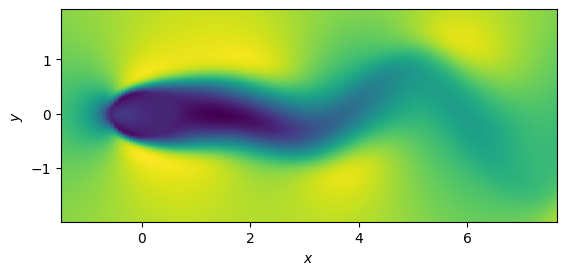

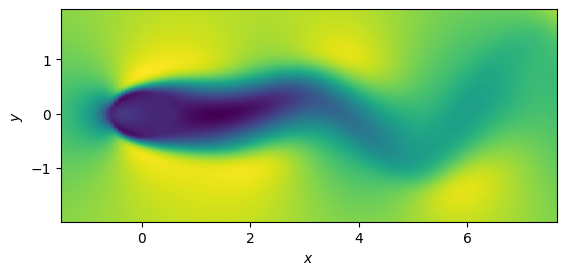

In [ ]:
for time_slice in reg_data[::len(reg_data) // 3]:
    plt.imshow(time_slice[..., 0], extent=[np.min(x), np.max(x), np.min(y), np.max(y)], origin="lower")
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    plt.show()

### Extract observables

In [5]:
# Generate a grid of obserables
x_obs = np.linspace(1.0, 7.0, 5)
y_obs = np.linspace(-1.5, 1.5, 5)

xx_obs, yy_obs = np.meshgrid(x_obs, y_obs)

target_points = np.stack([xx_obs.flatten(), yy_obs.flatten()], axis=1)

coords.shape

(131, 100, 2)

In [6]:
point_index = np.argmin(
    np.linalg.norm(
        coords.reshape((coords.shape[0] * coords.shape[1], 1, 2)) - target_points[np.newaxis, ...],
        axis=2,
    ),
    axis=0,
)
points = coords.reshape((coords.shape[0] * coords.shape[1], 2))[point_index]

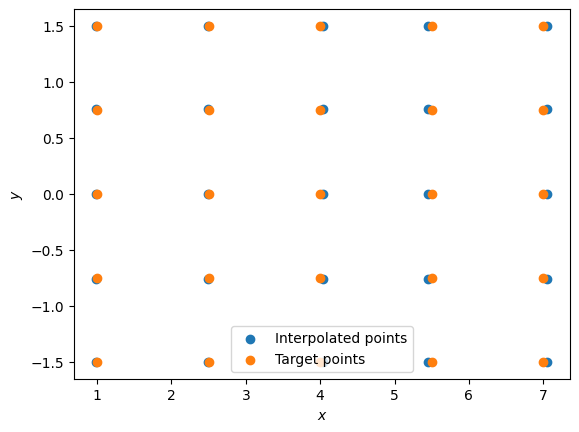

In [7]:
plt.scatter(*np.split(points, 2, axis=1), label="Interpolated points")
plt.scatter(*np.split(target_points, 2, axis=1), label="Target points")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend()
plt.show()

In [7]:
# Transform data and extract observables
train = [(traj - traj[0])[TRUNC_INDEX:, point_index, DIM] for traj in data]
del data  # Free memory

### Compute SVD

In [9]:
if DIM == 0:
    V = np.linalg.svd(train[:].T)[2]

In [10]:
plt.plot(V[2,:])

NameError: name 'V' is not defined

In [8]:
ssm_list = []
for traj in train:
    ssm = SSMLearn(
        t=[0.012 * np.arange(traj.shape[0])],  # shape: traj, time
        x=[traj.T],  # shape: traj, dim, time
        reduced_coordinates=[V[1:3, :]] if DIM == 0 else None,
        ssm_dim=2,
        dynamics_structure="normalform",
    )

    ssm.get_reduced_coordinates()
    ssm.get_parametrization(poly_degree=DEGREE)
    ssm.get_reduced_dynamics(poly_degree=DEGREE, normalform_args = {
        'degree': 3, 
        'do_scaling': False,
        'tolerance': None,
        'ic_style': 'random',
        'method': 'lm',
        'jac': '2-point',
        'max_iter': 1000,
        'use_center_manifold_style' : True}
    )

    ssm_list.append(ssm)

INFO   2025-04-17 19:40:04 main Getting coordinates embeddings
INFO   2025-04-17 19:40:04 ridge Transforming data
INFO   2025-04-17 19:40:04 ridge Skipping CV on ridge regression
INFO   2025-04-17 19:40:04 ridge Fitting regression model
INFO   2025-04-17 19:40:04 ridge Transforming data
INFO   2025-04-17 19:40:04 ridge Skipping CV on ridge regression
INFO   2025-04-17 19:40:04 ridge Fitting regression model
INFO   2025-04-17 19:40:04 main Getting coordinates embeddings
INFO   2025-04-17 19:40:04 ridge Transforming data
INFO   2025-04-17 19:40:04 ridge Skipping CV on ridge regression
INFO   2025-04-17 19:40:04 ridge Fitting regression model
INFO   2025-04-17 19:40:04 ridge Transforming data
INFO   2025-04-17 19:40:04 ridge Skipping CV on ridge regression
INFO   2025-04-17 19:40:04 ridge Fitting regression model
INFO   2025-04-17 19:40:04 main Getting coordinates embeddings
INFO   2025-04-17 19:40:04 ridge Transforming data
INFO   2025-04-17 19:40:04 ridge Skipping CV on ridge regression

In [ ]:
from scipy.integrate import solve_ivp

def predict(ssm, x0, t, t_eval=None):
    # Map observables to reduced coordinates
    w0 = ssm.normalform_transformation.inverse_transform(ssm.encode(x0.T))
    w0 = w0[:, 0]
    # Evolve the normal form dynamics
    sol = solve_ivp(ssm.reduced_dynamics.map_info["vectorfield"], [0., t], w0, t_eval=t_eval, method="DOP853")
    # Map back to observables
    eta_traj = ssm.normalform_transformation.transform(sol.y)
    return sol.t, ssm.decode(eta_traj.real)

In [78]:
print(train[0].shape)

(3033, 25)


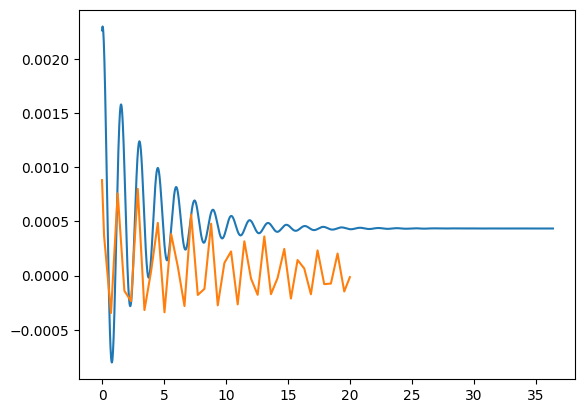

In [93]:
x0 = train[0]
# t, x = predict(ssm, x0, 20.0)
t, x = temp_predict(x0, 20.0)

obs = 0

plt.plot(0.012 * np.arange(train[0].shape[0]), train[0][:, obs], label="True")
plt.plot(t, x[obs, :], label="Fitted")
plt.show()


# plt.plot(train[-1][])

In [90]:
from scipy.interpolate import interp1d
from ssmlearnpy.reduced_dynamics.normalform import NonlinearCoordinateTransform
from ssmlearnpy.geometry.dimensionality_reduction import LinearChart
from ssmlearnpy.utils.preprocessing import compute_polynomial_map, insert_complex_conjugate
from typing import Callable

def interp1v(params: list[float], data: list[np.ndarray]) -> Callable[[float], np.ndarray]:
    return interp1d(np.array(params), np.array(data).transpose(*range(1, len(data[0].shape) + 1), 0))


def interpolate_ssm(ssm_list: list[SSMLearn], re_list: list[str]) -> tuple:
    # Interpolate obs -> reduced
    encoder_mat = interp1v(re_list, [ssm.encoder.matrix_representation for ssm in ssm_list])
    encoder = lambda re: LinearChart(2, encoder_mat(re))

    decoder_mat = interp1v(re_list, [ssm.decoder.map_info["coefficients"] for ssm in ssm_list])
    decoder = lambda re: (lambda x: compute_polynomial_map(decoder_mat(re), DEGREE)(x))

    # Interpolate reduced -> normal
    inverse_transform_coeff = interp1v(re_list, [ssm.normalform_transformation.inverse_transform_coefficients for ssm in ssm_list])
    transform_coeff = interp1v(re_list, [ssm.normalform_transformation.transform_coefficients for ssm in ssm_list])
    linear_transform = interp1v(re_list, [ssm.normalform_transformation.linear_transform for ssm in ssm_list])

    normalform_transformation = lambda re: NonlinearCoordinateTransform(2, 3, transform_coeff(re), inverse_transform_coeff(re), linear_transform(re))

    # Interpolate dynamics
    coeff_dynamics = interp1v(re_list, [ssm.reduced_dynamics.coeff_dynamics for ssm in ssm_list])

    return encoder, decoder, normalform_transformation, coeff_dynamics


def predict_from_interp(encoder: Callable, decoder: Callable, normalform_transformation: Callable, coeff_dynamics: np.ndarray) -> Callable:
    """Produce a pseudo-SSM for time evolution of interpolated quantities."""


    def vectorfield(t, x):
        xeval = x.reshape(-1,1)
        evaluation = compute_polynomial_map(coeff_dynamics, DEGREE)(xeval).T
        # need to reshape this for the complex_polynomial_features function
        return insert_complex_conjugate(evaluation)[:,0]
     

    def predict(x0, t, t_eval=None) -> tuple[np.ndarray, np.ndarray]:
        """Evolve an initial state through time using reduced dynamics."""
        # Map observables to reduced coordinates
        eta0 = encoder.predict(x0.T)
        w0 = normalform_transformation.inverse_transform(eta0)
        w0 = w0[:, 0]
        
        # Evolve the normal form dynamics
        sol = solve_ivp(vectorfield, [0., t], w0, t_eval=t_eval, method="DOP853")

        # Map back to observables
        eta_traj = normalform_transformation.transform(sol.y)

        return sol.t, decoder(eta_traj.real)

    return predict

In [91]:
encoder, decoder, normalform_transformation, coeff_dynamics = interpolate_ssm(ssm_list, RE_VALS)

In [92]:
re = 55
temp_predict = predict_from_interp(encoder(re), decoder(re), normalform_transformation(re), coeff_dynamics(re))

In [13]:
plotter = Plot(
    label_observables="x",
    label_reduced_coordinates="eta",
)

In [14]:
fig = plotter.make_plot(ssm, idx_coordinates=[20])
fig.show()

In [40]:
fig = plotter.make_plot(ssm_list[2], data_name="reduced_coordinates", idx_trajectories=[0], idx_coordinates=[1, 2])
fig.show()

In [41]:
fig = plotter.make_plot(ssm_list[2], data_name="observables", idx_trajectories=[0], idx_coordinates=[1, 2, 4],
                        with_predictions=False, add_surface=True)
fig.show()

## Extract normal form dynamics

In [42]:
import ssmlearnpy.utils.postprocessing as postprocessing

ssm = ssm_list[0]

var, varbar, eqs = postprocessing.display_equation(ssm.reduced_dynamics.map_info['coefficients'], ssm.reduced_dynamics.map_info['exponents'], base_symbol='z', complex=True)

postprocessing.disp('\\dot{z}_0=', eqs[0])
postprocessing.disp('\\dot{\\bar{z}}_0=', eqs[1])

variables = [var[0], varbar[0]]
r, phi, req, phieq = postprocessing.convert_to_polar(variables, eqs)

postprocessing.disp('\\dot{r}_0=', req[0])
postprocessing.disp('\\dot{\\varphi}_0=', phieq[0])
